# Supplementary Analysis

*This notebook was run using:*
 Windows 10 (64-bit) with 16 gb ram minimum and a AMD Ryzen 7 3750H CPU @ 2.30 GHz

# Protein Identification by Nanopore Peptide Profiling
###  <ins>Florian L. R. Lucas</ins>$^{1}$, Roderick C. A. Versloot$^{1}$, Liubov Yakovlieva$^{2}$, Marthe T. C. Walvoort$^{2}$,Giovanni Maglia$^{1*}$  
$^{1}$_Groningen Biomolecular Sciences and Biotechnology Institute, University of Groningen, Groningen, Netherlands_  
$^{2}$_Stratingh Institute for Chemistry, University of Groningen, Groningen, Netherlands_  

# Before starting (first time), non-standard libraries.

Open __Anaconda Prompt__ in windows, this will open the anaconda terminal.
<br>
It should something like this:
~~~~
(base) C:\Users\user>
~~~~
Enter `pip install neo`, If it asks if you want to install, enter `Y` and press enter.
<br>
Wait untill it finished installing, you're ready to begin.

# Data Analysis
### Define folder path
We use a variable, `notebook_path`, to refer to the path folder.<br>
Change the `notebook_path` to the path of the folder.
##### Common errors:
> The drive name should be read with two slashes (e.g. C:\\\\).
>
> The path name should not be too long, make it shorter.

In [86]:
notebook_path=input("now,please enter the upper folder's path of the data and the scripts")


#### Parameters
Here we define the parameters used throughout the script.

>`n_bins` (*int*): The standard number of bins for making histograms
>
>`Fs` (*float*): Filter frequency in Hertz
>
>`minimal_dwelltime` (*float*): Minimal dwelltime of events in seconds
>
>`offset` (*float*): Ignore the first x seconds from traces
>
>`histogram_dwelltimes` (*list of tuples*): Pairs of dwelltimes (s) to use for the histograms (time filtered)
>
>`use_sNDF` (*boolean*): Fit super flat-top Normal Distribution Function if True, else don't

In [87]:
n_bins = 200 # The standard number of bins for making histograms
Fs = 5000 # Filter frequency in Hertz
minimal_dwelltime = 4e-4 # Minimal dwelltime of events in seconds
offset = 1.8 # Ignore the first x seconds from traces
histogram_dwelltimes = [(4e-4, 1e-3), (5e-4, 20e-3)] # Pairs of dwelltimes (s) to use for the histograms (time filtered)
use_sNDF = True # Fit super flat-top Normal Distribution Function if True, else don't
reload = True
# reload = False

### Load the required libraries
We use the following libraries:
>__System Standard__
>
>`sys` (version: *3.6.4*)<br>
>`logging` (version: *0.5.1.2*)<br>
>`warnings` (system default)<br>
>
>__From the Python Package Index__
>
>`NumPy` (version: *1.14.3*, import as: `np`)<br>
>`Pandas` (version: *0.23.0*, import as: `pd`)<br>
>`scipy` (version: *1.1.0*, import `signal.savgol_filter`)<br>
>`matplotlib` (version: *2.2.2*, import as `mpl`)<br>
>`seaborn` (version: *0.8.1*, import as `sns`)<br>
>`neo` (version: *0.6.1*)<br>
>`biopython` (version: *1.77*)<br>
>
>__Supplementary Package(s)__
>
>`nanolyse` (import as `nl`)<br>
>`CollectData` <br>
>`NanoMatch` <br>
>`ScoreSpectra` <br>
>`ProteinDigest`

In [88]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from scipy import signal
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
# To enable logging, e.g. for warning and errors
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Supress warnings, usually they just cloud jupyter-notebook, we can access all warnings using logging.
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0, notebook_path + "./python_scripts")
import nanolyse as nl

from CollectData import *
from NanoMatch import *
from ScoreSpectra import *
from ProteinDigest import *
from IPython.display import Latex
Latex(r"$f(x) = 3x + 7$")

<IPython.core.display.Latex object>

In [89]:
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

In [90]:
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

#### Normal Distribution Function (NDF)

In [91]:
def NDF(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

#### Sum of Normal Distribution functions

In [92]:
def mmult_NDF(x, *args):
    y = np.zeros(len(x))
    for i in range( int((len(args) - len(args) % 3) / 3) ):
        y += NDF(x, *args[i*3:(i+1)*3])
    return y

#### Logistic function, derivates and inverse

In [93]:
def logistic(x, x0, k, a):
    return ((100-a)/100)*(100/(1+np.exp(-(1/k)*(x-x0)))) + a

In [94]:
def logistic_derivative(x, x0, k, a):
    e_term = np.exp((x-x0)/k)
    return ((100-a)*e_term)/(k*(e_term+1)**2)

In [95]:
def logistic_inverse(y, x0, k, a):
    return -k*np.log(((100-a)/(y-a))-1)+x0

In [96]:
def logistic_inverse_derivative(y, x0, k, a):
    return -1*((a-100)*k)/((y-100)*(a-y))

#### Set the standard excluded current (I<sub>ex</sub>) bins
Here, we define the bins used for the excluded current spectra. The data is binned in `n_bins + 1` bins, so the edges of the bins are `n_bins` long, as defined before in the script.

In [97]:
Iex_bins = np.linspace( 0, 1, n_bins + 1 )
Iex_edges = np.linspace( 0, 1, n_bins )

In [98]:
results_cols = ['Folder', 'Protein', 'Blank Signal', 'Signal', 'Iex BLANK', 
                'Iex SD2 BLANK', 'dwelltime BLANK', 'beta BLANK', 'fit params BLANK', 
                'Iex', 'Iex SD2', 'dwelltime', 'beta', 'fit params']

In [99]:
results_load_cols = ['Folder', 'Protein', 'Iex BLANK', 
                'Iex SD2 BLANK', 'dwelltime BLANK', 'beta BLANK', 'fit params BLANK', 
                'Iex', 'Iex SD2', 'dwelltime', 'beta', 'fit params']

In [100]:
Iex_bins_filt = np.linspace( 0.4, 1, n_bins + 1 )
Iex_edges_filt = np.linspace( 0.4, 1, n_bins )

In [101]:
from NanoMatch import *
NM = NanoMatch( Iex_bins=Iex_bins_filt, Iex_edges=Iex_edges_filt )

## Model peptides

### Loading the data
The following code loads the file locations and additional information into `main_index`.

The structure of the data files is registered in __'index.csv'__ contained in the data folder. 
In this file, we describe the protein that was measured as well as the folder location and the expected baseline / standard deviation.<br><br>
__Example of *./data/index.csv*__

|Protein (string)|Folder (string)|Baseline (pA) (float)|Baseline Error (pA) (float)|
|---|---|---|---|
|trypsin|/trypsin/0000/|-126.3|1.9|
|trypsin|/trypsin/0001/|-117.8|2.0|
|trypsin|/trypsin/0002/|-122.4|2.2|
|lysozyme|/lysozyme/0000/|115.5|2.2|
|...|...|...|...|

In each __Folder__, there is another __'index.csv'__, explaining which files are with protein and which are without (blank).<br><br>
__Example of *./data/trypsin/0000/index.csv*__

|blank (boolean)|fname (string)|
|---|---|
|True|2020_01_27_G13F_1M_KCl_50mM_CitricAcid_BTP_pH38_Blank_RV_0000|
|False|2020_01_27_G13F_1M_KCl_50mM_CitricAcid_BTP_pH38_20ul_Trypsin_TrypsinGoldDIgest_RV_0000|
|False|2020_01_27_G13F_1M_KCl_50mM_CitricAcid_BTP_pH38_20ul_Trypsin_TrypsinGoldDIgest_RV_0001|
|...|...|


In [102]:
peptide_index = pd.read_csv(notebook_path + './data/index_peptides.csv')

The results columns are loaded into the `results_cols` variable and a new instance of the `CollectData( notebook_path, results_cols, *args )` is made in method `CD`.

In [103]:
CD_peptides = CollectData(notebook_path, results_cols)

In [104]:
CD_peptides.collect_data(peptide_index, offset=offset, Fs=Fs, 
                         dwelltime=minimal_dwelltime, sNDF=use_sNDF, reload=reload)

The following function `CD.collect_results( main_index, results_load_cols, *args )` loads the results from the `main_index` structure.<br>
<br>
*__Notice:__ this can take some time, because it also checks if the results in the folder are not corrupted.*

In [105]:
results_peptides = CD_peptides.collect_results(peptide_index, results_load_cols)

The following function `CD.save_excel_results( notebook_path, main_index, Iex_bins, Iex_edges, offset, Fs, minimal_dwelltime, *args )` loads the results from the `main_index` structure, which is saved as __’results.pkl’__ file in the __’./data/’__ folder, and saves the I<sub>ex</sub>% and other important features in __'results_analysis.xlsx'__.

In [106]:
CD_peptides.save_excel_results(notebook_path, peptide_index, Iex_bins, Iex_edges, 
                               offset=offset, Fs=Fs, minimal_dwelltime=minimal_dwelltime)

Peptide centre estimation for fit

In [107]:
p0_Iex = [0.49, 0.52, 0.55, 0.59, 0.62, 0.78, 0.83]
cal_seq = ['TPGSR', 'CELAAAMK', 'HGLDNYR', 'WWCNDGR', 'GTDVQAWIR', 'GYSLGNWVCAAK', 'FESNFNTQATNR']

In [108]:
peptides_iex = np.array([])
peptides_dwt = np.array([])
for i, j in zip(results_peptides['Iex'], results_peptides['dwelltime']):#得到了两个储存Iex dwt的列表
    peptides_iex = np.concatenate((peptides_iex, i))
    peptides_dwt = np.concatenate((peptides_dwt, j))

Create excluded current spectra

In [109]:
# Allign spectra to ensure both spectra match
peptide_Iex_spectra = NM.get_spectra_all(results_peptides)
peptide_Iex_spectra = peptide_Iex_spectra[1][0]

In [110]:
peptide_Iex_centres = []
p0_popt = []
for iex_spec in peptide_Iex_spectra:
    
    p0 = []
    bounds = []
    for p0_iex in p0_Iex:
        p0 += [0.05, p0_iex, 0.01]
        bounds += [(0, 1),(p0_iex-0.05, p0_iex+0.05),(0, np.inf)]
    try:
        popt,_=curve_fit(mmult_NDF, Iex_edges_filt, iex_spec / max(iex_spec),p0=p0)
        peptide_Iex_centres.append(popt[1::][::3])
        p0_popt.append(popt)
    except:
        peptide_Iex_centres.append(p0[1::][::3])
        pass

Plot the excluded current spectrum (black) and standard deviation (red-dashed)

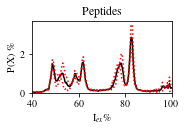

In [111]:
fig = NM.plot_Iex_spectra( results_peptides, allign=True )

Plot the excluded current (%) v the dwell time

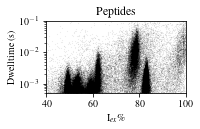

In [112]:
fig_Iex_DWT = NM.plot_Iex_dwelltime( results_peptides, allign=True )

In [113]:
PD = ProteinDigest(enzyme='trypsin')

Iex_LYSC = list(np.mean(peptide_Iex_centres, axis=0)*100)
Iex_SD_LYSC = list(np.std(peptide_Iex_centres, axis=0)*100)
cal_seq_LYSC = ['TPGSR', 'CELAAAMK', 'HGLDNYR', 'WWCNDGR', 'GTDVQAWIR', 'GYSLGNWVCAAK', 'FESNFNTQATNR']

peptide_mass_LYSC = [PD.get_peptide(i, 'mass') for i in cal_seq]

Fit logistic function

In [114]:
peptide_mass = peptide_mass_LYSC
Iex_peptides = Iex_LYSC

p0=[750, 300, 40]
popt_peptides, pcov_peptides = curve_fit(logistic, peptide_mass, Iex_peptides, p0=p0)

In [115]:
peptide_mass

[516.55468,
 893.0320800000001,
 873.92358,
 993.01228,
 1045.1630800000003,
 1325.45278,
 1428.48078]

In [116]:
def chavis2017(Mp, Mf, a, v, y):
    R = np.array(Mp) / Mf
    return 100*(1-(1-(R**v)*(1-a*(R**y)*((1-(R**(1-v)) )**-1) ) )**-1)

In [117]:
p0=[2000, 1.7, 0.6, 0.3]
bounds=((0,0,0,0),(np.inf,np.inf, 1, np.inf))
# p0, _ = curve_fit(chavis2017, np.linspace(500, 1500, 100), logistic(np.linspace(500, 1500, 100), *popt_peptides), p0=p0, bounds=bounds)
popt_peptides_chavis2017, pcov_peptides_chavis2017 = curve_fit(chavis2017, peptide_mass[1::], Iex_peptides[1::], p0=p0, bounds=bounds)
# popt_peptides_chavis2017, pcov_peptides_chavis2017 = curve_fit(chavis2017, peptide_mass, Iex_peptides, p0=p0)

In [118]:
popt_peptides_polyfit = np.poly1d(np.polyfit([0]+peptide_mass, [0]+Iex_peptides, 2))

[array([0.43997471, 0.48823927, 0.00705974, 0.09555938, 0.48617239,
       0.02818611, 0.57345477, 0.53177928, 0.01134898, 0.40498606,
       0.59726581, 0.03035534, 0.53215693, 0.61963832, 0.0053998 ,
       0.99383148, 0.82608357, 0.00778979, 0.81296429, 0.782385  ,
       0.01293411]), array([ 0.28349267,  0.48837034,  0.00567058,  0.27486685,  0.5063369 ,
        0.02270348, -0.44462135,  0.60255198, -0.00880754,  0.13241141,
        0.57613646,  0.00953668,  0.60270466,  0.60721314,  0.01491937,
        0.40395406,  0.76987977,  0.01779085,  0.99772337,  0.82801107,
        0.00794245])]


Text(-0.4, 1.15, 'C')

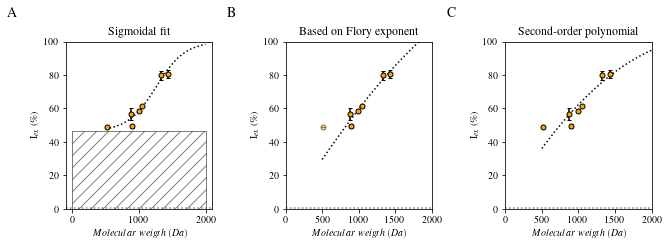

In [119]:
import matplotlib.pyplot as plt
fig_size = (7+3.5, 3)
fontsize = 10
letter_font_size = 14
fig = plt.figure( figsize=fig_size )
gs = plt.GridSpec( 1, 3, top=0.9, wspace=0.5, hspace=0)
ax0 = fig.add_subplot( gs[ 0, 0 ] )

ax0.set_title('Sigmoidal fit')
ax0.errorbar(peptide_mass, Iex_LYSC, yerr=Iex_SD_LYSC, marker='o', ls='None', 
             markersize=5, markeredgecolor='k', markeredgewidth=1, c='orange', ecolor='k', capsize=2)
x = np.linspace(500, 2000, 100)
ax0.plot( x, logistic( x, *popt_peptides ), ':k', markersize=20 )
print(p0_popt)
ax0.axhline(p0_popt[-1][0], c='k', linestyle=':', alpha=0.5)


ax0.fill_between([0, x[-1]], [0,0], [popt_peptides[-1], popt_peptides[-1]],
                 facecolor='none', interpolate=True, hatch='//', alpha=0.5)

ax0.set_ylim(0, 100)
ax0.set_ylabel(r'I$_{ex}$ (\%)', fontsize=fontsize)
ax0.set_xlabel(r'$Molecular$ $weigth$ $(Da)$', fontsize=fontsize)
ax0.text( -.4, 1.15, "A", transform=ax0.transAxes, size=letter_font_size, weight='bold' )

ax1 = fig.add_subplot( gs[ 0, 1 ] )

ax1.set_title('Based on Flory exponent')
ax1.errorbar(peptide_mass_LYSC[1::], Iex_LYSC[1::], yerr=Iex_SD_LYSC[1::], marker='o', ls='None', 
             markersize=5, markeredgecolor='k', markeredgewidth=1, c='orange', ecolor='k', capsize=2)

ax1.errorbar(peptide_mass_LYSC[0], Iex_LYSC[0], yerr=Iex_SD_LYSC[0], marker='o', ls='None', 
             markersize=5, markeredgecolor='k', markeredgewidth=1, c='orange', ecolor='k', capsize=2, alpha=0.5)


ax1.plot( x, chavis2017(x, *popt_peptides_chavis2017), ':k', markersize=20 )

ax1.axhline(p0_popt[-1][0], c='k', linestyle=':', alpha=0.5)


# ax1.fill_between([0, x[-1]], [0,0], [popt_peptides[-1], popt_peptides[-1]],
#                  facecolor='none', interpolate=True, hatch='//', alpha=0.5)


ax1.set_ylim(0, 100)
ax1.set_xlim(0, 2000)

ax1.set_ylabel(r'I$_{ex}$ (\%)', fontsize=fontsize)
ax1.set_xlabel(r'$Molecular$ $weigth$ $(Da)$', fontsize=fontsize)
ax1.text( -.4, 1.15, "B", transform=ax1.transAxes, size=letter_font_size, weight='bold' )


ax2 = fig.add_subplot( gs[ 0, 2 ] )

ax2.set_title('Second-order polynomial')
ax2.errorbar(peptide_mass_LYSC, Iex_LYSC, yerr=Iex_SD_LYSC, marker='o', ls='None', 
             markersize=5, markeredgecolor='k', markeredgewidth=1, c='orange', ecolor='k', capsize=2)

ax2.plot( x, popt_peptides_polyfit(x), ':k', markersize=20 )

ax2.axhline(p0_popt[-1][0], c='k', linestyle=':', alpha=0.5)


# ax2.fill_between([0, x[-1]], [0,0], [popt_peptides[-1], popt_peptides[-1]],
#                  facecolor='none', interpolate=True, hatch='//', alpha=0.5)

ax2.set_ylim(0, 100)
ax2.set_xlim(0, 2000)

ax2.set_ylabel(r'I$_{ex}$ (\%)', fontsize=fontsize)
ax2.set_xlabel(r'$Molecular$ $weigth$ $(Da)$', fontsize=fontsize)
ax2.text( -.4, 1.15, "C", transform=ax2.transAxes, size=letter_font_size, weight='bold' )






Text(-0.4, 1.15, 'b')

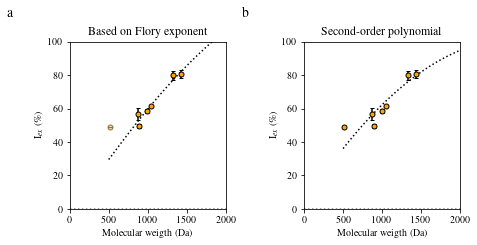

In [120]:
fig_size = (7, 3)
fontsize = 10
letter_font_size = 14
fig = plt.figure( figsize=fig_size )
gs = plt.GridSpec( 1, 2, top=0.9, wspace=0.5, hspace=0)

x = np.linspace(500, 2000, 100)


ax1 = fig.add_subplot( gs[ 0, 0 ] )

ax1.set_title('Based on Flory exponent')
ax1.errorbar(peptide_mass_LYSC[1::], Iex_LYSC[1::], yerr=Iex_SD_LYSC[1::], marker='o', ls='None', 
             markersize=5, markeredgecolor='k', markeredgewidth=1, c='orange', ecolor='k', capsize=2)

ax1.errorbar(peptide_mass_LYSC[0], Iex_LYSC[0], yerr=Iex_SD_LYSC[0], marker='o', ls='None', 
             markersize=5, markeredgecolor='k', markeredgewidth=1, c='orange', ecolor='k', capsize=2, alpha=0.5)


ax1.plot( x, chavis2017(x, *popt_peptides_chavis2017), ':k', markersize=20 )

ax1.axhline(popt[-1], c='k', linestyle=':', alpha=0.5)


# ax1.fill_between([0, x[-1]], [0,0], [popt_peptides[-1], popt_peptides[-1]],
#                  facecolor='none', interpolate=True, hatch='//', alpha=0.5)


ax1.set_ylim(0, 100)
ax1.set_xlim(0, 2000)

ax1.set_ylabel(r'I$_{ex}$ (\%)', fontsize=fontsize)
ax1.set_xlabel(r'Molecular weigth (Da)', fontsize=fontsize)
ax1.text( -.4, 1.15, "a", transform=ax1.transAxes, size=letter_font_size, weight='bold' )


ax2 = fig.add_subplot( gs[ 0, 1 ] )

ax2.set_title('Second-order polynomial')
ax2.errorbar(peptide_mass_LYSC, Iex_LYSC, yerr=Iex_SD_LYSC, marker='o', ls='None', 
             markersize=5, markeredgecolor='k', markeredgewidth=1, c='orange', ecolor='k', capsize=2)

ax2.plot( x, popt_peptides_polyfit(x), ':k', markersize=20 )

ax2.axhline(popt[-1], c='k', linestyle=':', alpha=0.5)


# ax2.fill_between([0, x[-1]], [0,0], [popt_peptides[-1], popt_peptides[-1]],
#                  facecolor='none', interpolate=True, hatch='//', alpha=0.5)

ax2.set_ylim(0, 100)
ax2.set_xlim(0, 2000)

ax2.set_ylabel(r'I$_{ex}$ (\%)', fontsize=fontsize)
ax2.set_xlabel(r'Molecular weigth (Da)', fontsize=fontsize)
ax2.text( -.4, 1.15, "b", transform=ax2.transAxes, size=letter_font_size, weight='bold' )


In [121]:
fig.savefig('Figure_S1.pdf', format='pdf', dpi=1200, bbox_inches = "tight")

In [122]:
popt_peptides_polyfit

poly1d([-1.32572871e-05,  7.22794936e-02,  3.27672373e+00])

In [123]:
popt_peptides_chavis2017

array([1.82586542e+03, 9.76074082e-01, 2.67601172e-01, 3.27912864e-25])

Text(0, -0.6, '$\\gamma$: 0.0')

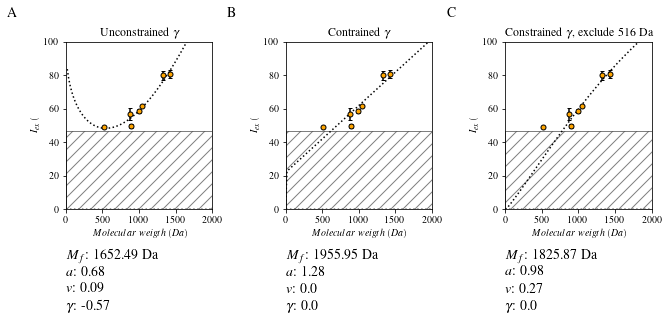

In [124]:
fig_size = (7+3.5, 3)
fontsize = 10
letter_font_size = 14
fig = plt.figure( figsize=fig_size )
gs = plt.GridSpec( 1, 3, top=0.9, wspace=0.5, hspace=0)
ax0 = fig.add_subplot( gs[ 0, 0 ] )

ax0.set_title('Unconstrained $\gamma$')
ax0.errorbar(peptide_mass_LYSC, Iex_LYSC, yerr=Iex_SD_LYSC, marker='o', ls='None', 
             markersize=5, markeredgecolor='k', markeredgewidth=1, c='orange', ecolor='k', capsize=2)
x = np.linspace(0, 2000, 100)

p0=[2000, 1.7, 0.6, 0.3]
bounds=((0,0,0,-np.inf),(np.inf,np.inf, 1, np.inf))
popt_peptides_chavis2017, pcov_peptides_chavis2017 = curve_fit(chavis2017, peptide_mass, Iex_peptides, p0=p0, bounds=bounds)

ax0.plot( x, chavis2017(x, *popt_peptides_chavis2017), ':k', markersize=20 )
ax0.axhline(popt[-1], c='k', linestyle=':', alpha=0.5)


ax0.fill_between([0, x[-1]], [0,0], [popt_peptides[-1], popt_peptides[-1]],
                 facecolor='none', interpolate=True, hatch='//', alpha=0.5)

ax0.set_ylim(0, 100)
ax0.set_xlim(0, 2000)

ax0.set_ylabel(r'$I_{ex}$ $($%$)$', fontsize=fontsize)
ax0.set_xlabel(r'$Molecular$ $weigth$ $(Da)$', fontsize=fontsize)
ax0.text( -.4, 1.15, "A", transform=ax0.transAxes, size=letter_font_size, weight='bold' )

ax0.text( 0, -0.3, "$M_f$: %s Da" % np.round(popt_peptides_chavis2017[0],2), transform=ax0.transAxes, size=letter_font_size )
ax0.text( 0, -0.4, "$a$: %s" % np.round(popt_peptides_chavis2017[1],2), transform=ax0.transAxes, size=letter_font_size )
ax0.text( 0, -0.5, "$v$: %s" % np.round(popt_peptides_chavis2017[2],2), transform=ax0.transAxes, size=letter_font_size )
ax0.text( 0, -0.6, "$\gamma$: %s" % np.round(popt_peptides_chavis2017[3],2), transform=ax0.transAxes, size=letter_font_size )


ax1 = fig.add_subplot( gs[ 0, 1 ] )

p0=[2000, 1.7, 0.6, 0.3]
bounds=((0,0,0,0),(np.inf,np.inf, 1, np.inf))
popt_peptides_chavis2017, pcov_peptides_chavis2017 = curve_fit(chavis2017, peptide_mass, Iex_peptides, p0=p0, bounds=bounds)

ax1.set_title('Contrained $\gamma$')
ax1.errorbar(peptide_mass_LYSC, Iex_LYSC, yerr=Iex_SD_LYSC, marker='o', ls='None', 
             markersize=5, markeredgecolor='k', markeredgewidth=1, c='orange', ecolor='k', capsize=2)


ax1.plot( x, chavis2017(x, *popt_peptides_chavis2017), ':k', markersize=20 )

ax1.axhline(popt[-1], c='k', linestyle=':', alpha=0.5)


ax1.fill_between([0, x[-1]], [0,0], [popt_peptides[-1], popt_peptides[-1]],
                 facecolor='none', interpolate=True, hatch='//', alpha=0.5)


ax1.set_ylim(0, 100)
ax1.set_xlim(0, 2000)

ax1.set_ylabel(r'$I_{ex}$ $($%$)$', fontsize=fontsize)
ax1.set_xlabel(r'$Molecular$ $weigth$ $(Da)$', fontsize=fontsize)
ax1.text( -.4, 1.15, "B", transform=ax1.transAxes, size=letter_font_size, weight='bold' )

ax1.text( 0, -0.3, "$M_f$: %s Da" % np.round(popt_peptides_chavis2017[0],2), transform=ax1.transAxes, size=letter_font_size )
ax1.text( 0, -0.4, "$a$: %s" % np.round(popt_peptides_chavis2017[1],2), transform=ax1.transAxes, size=letter_font_size )
ax1.text( 0, -0.5, "$v$: %s" % np.round(popt_peptides_chavis2017[2],2), transform=ax1.transAxes, size=letter_font_size )
ax1.text( 0, -0.6, "$\gamma$: %s" % np.round(popt_peptides_chavis2017[3],2), transform=ax1.transAxes, size=letter_font_size )



ax2 = fig.add_subplot( gs[ 0, 2 ] )

p0=[2000, 1.7, 0.6, 0.3]
bounds=((0,0,0,0),(np.inf,np.inf, 1, np.inf))
popt_peptides_chavis2017, pcov_peptides_chavis2017 = curve_fit(chavis2017, peptide_mass[1::], Iex_peptides[1::], p0=p0, bounds=bounds)

ax2.set_title('Constrained $\gamma$, exclude 516 Da')
ax2.errorbar(peptide_mass_LYSC, Iex_LYSC, yerr=Iex_SD_LYSC, marker='o', ls='None', 
             markersize=5, markeredgecolor='k', markeredgewidth=1, c='orange', ecolor='k', capsize=2)

ax2.plot( x, chavis2017(x, *popt_peptides_chavis2017), ':k', markersize=20 )

ax2.axhline(popt[-1], c='k', linestyle=':', alpha=0.5)


ax2.fill_between([0, x[-1]], [0,0], [popt_peptides[-1], popt_peptides[-1]],
                 facecolor='none', interpolate=True, hatch='//', alpha=0.5)

ax2.set_ylim(0, 100)
ax2.set_xlim(0, 2000)

ax2.set_ylabel(r'$I_{ex}$ $($%$)$', fontsize=fontsize)
ax2.set_xlabel(r'$Molecular$ $weigth$ $(Da)$', fontsize=fontsize)
ax2.text( -.4, 1.15, "C", transform=ax2.transAxes, size=letter_font_size, weight='bold' )

ax2.text( 0, -0.3, "$M_f$: %s Da" % np.round(popt_peptides_chavis2017[0],2), transform=ax2.transAxes, size=letter_font_size )
ax2.text( 0, -0.4, "$a$: %s" % np.round(popt_peptides_chavis2017[1],2), transform=ax2.transAxes, size=letter_font_size )
ax2.text( 0, -0.5, "$v$: %s" % np.round(popt_peptides_chavis2017[2],2), transform=ax2.transAxes, size=letter_font_size )
ax2.text( 0, -0.6, "$\gamma$: %s" % np.round(popt_peptides_chavis2017[3],2), transform=ax2.transAxes, size=letter_font_size )



In [125]:
fig.savefig('Figure_Flory.png', format='png', dpi=1200, bbox_inches = "tight")

Plot the data

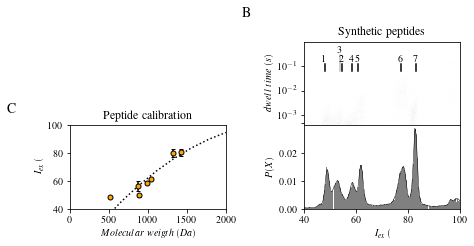

In [126]:
fig_size = (7, 3)
fontsize = 10
letter_font_size = 14
fig = plt.figure( figsize=fig_size )
gs = plt.GridSpec( 2, 2, top=0.9, wspace=0.5, hspace=0)
ax0 = fig.add_subplot( gs[ 1, 0 ] )

ax0.set_title('Peptide calibration')
ax0.errorbar(peptide_mass_LYSC, Iex_LYSC, yerr=Iex_SD_LYSC, marker='o', ls='None', 
             markersize=5, markeredgecolor='k', markeredgewidth=1, c='orange', ecolor='k', capsize=2)
x = np.linspace(0, 2000, 10)
ax0.plot( x, popt_peptides_polyfit( x ), ':k', markersize=20 )
ax0.axhline(popt[-1], c='k', linestyle=':', alpha=0.5)


#ax0.fill_between([0, x[-1]], [0,0], [popt_peptides[-1], popt_peptides[-1]],
#                 facecolor='none', interpolate=True, hatch='//', alpha=0.5)

ax0.set_ylim(40, 100)
ax0.set_xlim(0, 2000)

ax0.set_ylabel(r'$I_{ex}$ $($%$)$', fontsize=fontsize)
ax0.set_xlabel(r'$Molecular$ $weigth$ $(Da)$', fontsize=fontsize)
ax0.text( -.4, 1.15, "C", transform=ax0.transAxes, size=letter_font_size, weight='bold' )


ax1 = fig.add_subplot( gs[ 0, 1 ] )

ax1.set_title('Synthetic peptides')

ax1.semilogy(peptides_iex[::10]*100, peptides_dwt[::10], '.k', markersize=0.005)
ax1.set_ylabel(r'$dwell$ $time$ $(s)$', fontsize=fontsize)
ax1.set_xticks([])

ax1.set_ylim(4e-4, 1)
ax1.set_xlim(40, 100)
ax1.set_yticks([5e-4, 1e-3, 1e-2, 1e-1])


ax2 = fig.add_subplot( gs[ 1, 1 ] )

dx = np.diff(Iex_edges_filt*100)[0]
ax2.plot(Iex_edges_filt*100, savgol_filter(np.mean(peptide_Iex_spectra, axis=0), 7, 3), 'k', linewidth=0.5, alpha=1)
ax2.bar(Iex_edges_filt*100, np.mean(peptide_Iex_spectra, axis=0), color='grey', width=0.3, edgecolor='k', linewidth=dx-0.3)

# ax2.plot(Iex_edges_filt*100, np.mean(peptide_Iex_spectra, axis=0), 'k')
ax2.set_ylabel(r'$P(X)$ %', fontsize=fontsize)
ax2.set_xlabel(r'$I_{ex}$ $($%$)$', fontsize=fontsize)
ax2.text( -.4, 2.30, "B", transform=ax2.transAxes, size=letter_font_size, weight='bold' )

ax2.set_ylim(0, 0.03)
ax2.set_yticks([0, 0.01, 0.02])
ax2.set_xlim(40, 100)

Iex_centre = [0.49, 0.52, 0.55, 0.59, 0.62, 0.78, 0.83]
Seq = ['TPGSR', 'CELAAAMK', 'HGLDNYR', 'WWCNDGR', 'GTDVQAWIR', 'GYSLGNWVCAAK', 'FESNFNTQATNR']
pred_iex = logistic([PD.get_peptide(i, 'mass') for i in Seq], *popt_peptides)
# for iex, seq in zip(Iex_centre, Seq):
k = 0
for c, iex in enumerate(pred_iex):
    if k!=2:
        ax1.axvline(iex, ymin=0.65, ymax=0.73, c='k')
        ax1.text( ( ( iex/100 - 0.4 ) / 0.6 ) -0.02, 0.76, c+1, transform=ax1.transAxes, 
                 size=fontsize )
    else:
        ax1.axvline(iex, ymin=0.65, ymax=0.84, c='k', alpha=0.25)
        ax1.text( ( ( iex/100 - 0.4 ) / 0.6 ) -0.02, 0.87, c+1, transform=ax1.transAxes, 
                 size=fontsize )
    k += 1

**Figure 1. Lysozyme fingerprinting using FraC-G13W-T1 nanopores. A.** Excluded current spectrum as obtained from the measurement of a equimolar mixture of the peptides expected from Gallus-gallus lysozyme. **B.** Mass of model peptides from tryptic Gallus-gallus lysozyme (orange) set against the measured excluded current (%). The dashed line represents a logistic function fit through the data. The dashed area represents the excluded current that is inaccessible according to the logistic function fit. 

## Protein detection

Loading the data (*vide supra*)

In [127]:
main_index = pd.read_csv( notebook_path + './data/index.csv')

The results columns are loaded into the `results_col` variable and a new instance of the `CollectData( notebook_path, results_cols, *args )` is made in method `CD`.

In [128]:
results_cols = ['Folder', 'Protein', 'Blank Signal', 'Signal', 'Iex BLANK', 
                'Iex SD2 BLANK', 'dwelltime BLANK', 'beta BLANK', 'fit params BLANK', 
                'Iex', 'Iex SD2', 'dwelltime', 'beta', 'fit params']
CD = CollectData( notebook_path, results_cols )

The following code determines the events for each folder (for the blank and all measurements), and if use_sNDF=True, it will also fit a flat-top Gaussian Normal Densitiy function.

The instance of `CD` was defined in the previous block, the function `collect_data( main_index, offset, Fs, dwelltime, sNDF, reload, *args)` is called to pick the events. All the arguments are filled using `variable==var`, where the value equal to `var`. The variables were defined in the beginning of the notebook.

This function first picks the events in the data files using `nl.thresholdseach()` function, after which, if `==True`, it will fit generalized flat-top Normal Distribution Functions for accurate feature extraction using `nl.fit_sNDF()` and `nl.features_sNDF()`.

In [129]:
CD.collect_data( main_index, offset=offset, Fs=Fs, dwelltime=minimal_dwelltime, sNDF=use_sNDF, reload=reload )

The following function `CD.collect_results( main_index, results_load_cols, *args )` loads the results from the `main_index` structure.<br>
<br>
*__Notice:__ this can take some time, because it also checks if the results in the folder are not corrupted.*

In [130]:
results = CD.collect_results( main_index, results_load_cols )

In [131]:
results

,Folder,Protein,Iex BLANK,Iex SD2 BLANK,dwelltime BLANK,beta BLANK,fit params BLANK,Iex,Iex SD2,dwelltime,beta,fit params
0,/trypsin/0000/,trypsin,"[0.9538214292319751, 0.4522082474919981, 0.227...","[4.617244341186434, 5.334630690813498, 5.18623...","[0.004902869379764273, 0.0006341715037863347, ...","[6.278339074679088, 2.1726540248699964, 1.9182...","[[122.48823292671688, 0.055486473277995364, 0....","[0.8281339041724566, 0.592237702205043, 0.5197...","[36.088679997351576, 21.8487058025333, 20.7216...","[0.41311192228296006, 0.0008391943096375016, 0...","[53.09296189811264, 2.3387036010417335, 1.8795...","[[107.02198783477901, 0.20650667687496682, 0.1..."
0,/trypsin/0001/,trypsin,"[0.49240482031059457, 0.36522456243761287, 0.6...","[5.2240548373141795, 4.144768862405011, 5.0146...","[0.041215875629109125, 0.00041094293788066004,...","[19.16501405113127, 1.9758219278178144, 6.2859...","[[58.62338226906237, 0.1458046944805071, 0.014...","[0.5972226751164228, 0.47419970647137244, 0.48...","[10.097801663079169, 10.236242934015998, 26.93...","[0.0004312363249945661, 0.001725466501592213, ...","[1.8221179547458093, 3.153122640791688, 2.3044...","[[70.60981528988174, 0.10824725889532047, 0.00..."
0,/trypsin/0002/,trypsin,"[0.12477698843633081, 0.5043808402383851, 0.98...","[4.442496234208563, 5.414149997208089, 4.48337...","[0.000695587662573055, 0.0005064688277284649, ...","[1.7329582943661372, 2.3650037317176245, 9.562...","[[15.466657623968166, 0.1273274590157586, 0.00...","[0.8824460031802437, 0.8937303363260197, 0.647...","[26.041056432830672, 42.03134363432215, 6.7785...","[0.004472768651765846, 0.00749167982162339, 0....","[6.14891397688524, 7.9958660831978605, 2.20167...","[[108.1648872753822, 0.11583383312436614, 0.00..."
0,/lysozyme/0000/,lysozyme,"[0.7156334970885555, 0.6067179384638132, 0.212...","[4.453869151633548, 6.070081319355468, 6.38363...","[0.0025914276191173866, 0.0007468611374850635,...","[4.765728376619353, 2.595151176641494, 3.61228...","[[83.13790442465725, 0.3027614366073337, 0.000...","[0.5776836175181221, 0.5503349094205927, 0.576...","[4.967030254826987, 24.498986641217183, 19.108...","[0.0007131307963644268, 0.002805976563828193, ...","[2.720465474328594, 5.212789530996405, 8.05990...","[[66.76229292146644, 0.08725057729013806, 0.00..."
0,/lysozyme/0001/,lysozyme,"[0.9634692374149526, 0.7763506334267689, 0.429...","[5.103478308011023, 4.573554562626401, 4.89473...","[0.007432729497241381, 0.02020908482918298, 0....","[3.615315742160621, 13.679624004309453, 2.2930...","[[103.22054440995586, 0.39124209367951435, 0.0...","[0.9692649825676726, 0.8434418918480895, 0.569...","[24.627747302682995, 46.289970132517524, 14.37...","[0.0067427208861766145, 0.004708845248669051, ...","[4.77747633655807, 6.477492092411036, 3.322862...","[[105.8698038379079, 0.045615703097241625, 0.0..."
0,/lysozyme/0002/,lysozyme,"[0.36847711397601807, 0.4756848610795509, 0.76...","[13.172591365477908, 12.638917686973334, 9.081...","[0.0004739467638963318, 0.0008953439393273603,...","[1.9083211634932042, 3.1131551181751886, 2.233...","[[39.59447322378212, 0.0792389152839887, 0.000...","[0.3069392471165182, 0.8343576949811724, 0.734...","[23.74909048954402, 23.11739419586992, 11.5959...","[0.0005608841258893474, 0.005826603751725068, ...","[2.0933781345217377, 6.944984911465371, 2.1744...","[[32.63556302196079, 0.0013143692456314626, 0...."
0,/cytochrome c/0000/,cytochrome c,"[0.6227742912400995, 0.9686539644641585, 0.781...","[8.700517823187887, 8.962877410299617, 4.52669...","[0.008151638439161325, 0.004132050498098097, 0...","[8.301884817394571, 6.053951019090749, 5.98929...","[[74.89045078802747, 0.39012282747357746, 0.00...","[0.7298069770166657, 0.8983755425606789, 0.793...","[12.341053600581072, 8.080707041687276, 6.6889...","[0.0015784226076408828, 0.0012284701216241636,...","[3.5599131459869295, 2.926383327902522, 3.5258...","[[86.57943600430248, 0.009224488781517869, 0.0..."
0,/cytochrome c/0001/,cytochrome c,"[0.21741540

The following function `CD.save_excel_results( notebook_path, main_index, Iex_bins, Iex_edges, offset, Fs, minimal_dwelltime, *args )` loads the results from the `main_index` structure, which is saved as __’results.pkl’__ file in the __’./data/’__ folder, and saves the I<sub>ex</sub>% and other important features in __'results_analysis.xlsx'__.

In [132]:
# CD.save_excel_results( notebook_path, main_index, Iex_bins, Iex_edges, offset=offset, Fs=Fs, minimal_dwelltime=minimal_dwelltime )

## Lysozyme protein digest (Nanopore v Mass spectrometry)

The following two code lines extract the lysozyme data and create the respective excluded current spectrum.

In [133]:
results_lysozyme = results.where( results.loc[:,'Protein'] == 'lysozyme' ).dropna()

In [134]:
_, lysozyme_Iex_spectra = NM.get_spectra_all(results_lysozyme)

We read the excel file containing the identified mass peaks (analysed using PEAKS). The spectrum is created by mapping the mass of each peptide (from sequence + PTMS) to an expected excluded current. We than apply an arbitrary standard deviation of 0.5 excluded current to generate an NDF profile. The sum of all peptide NDFs is saved.

In [135]:
LYSC_MS_PATH = notebook_path + './data/mass_spec/Lysozyme tryptic peptides.xlsx'
df = pd.read_excel(LYSC_MS_PATH)

import re
fragment_seq = []
fragment_mass = []
fragment_area = []

for peptide, area in zip(df['Peptide'], df['Area']):
    fragment_seq.append(re.sub("[\(\[].*?[\)\]]", "", peptide))
    fragment_mod = np.sum(
        [float(i) for i in re.findall(".*?\((.*?)\)", peptide)]
    )
    fragment_mass.append(PD.get_peptide(fragment_seq[-1], 'mass', cystein_mod=0) + fragment_mod)
    fragment_area.append(area)

n_res = 1001
STD = 0.5
y = np.zeros(len(Iex_edges_filt))
x = np.linspace(0, 100, n_res)
x = Iex_edges_filt*100
for seq, mass, area in zip(fragment_seq, fragment_mass, fragment_area):
    y += NDF(x, area, popt_peptides_polyfit(mass), STD)

We plot the excluded current spectrum of lysozyme (nanopore based) and the predicted excluded current spectrum, based on ESI-MS.

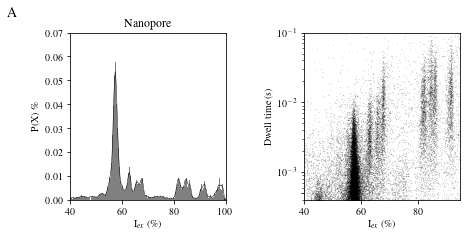

In [136]:
dx = np.diff(Iex_edges_filt*100)[0]
y_lys_MS = np.sqrt(y)/np.sum(np.sqrt(y))

fig_size = (7, 3)
fontsize = 10
letter_font_size = 14
fig = plt.figure( figsize=fig_size )
gs = plt.GridSpec( 1, 2, top=0.9, wspace=0.5, hspace=0.7)

ax0 = fig.add_subplot( gs[ 0, 0 ] )

y2 = np.mean(lysozyme_Iex_spectra[0], axis=0)
ax0.plot(Iex_edges_filt*100, savgol_filter(y2, 7, 3), 'k', linewidth=0.5, alpha=1)
ax0.bar(Iex_edges_filt*100, y2, color='grey', width=0.3, edgecolor='k', linewidth=dx-0.3)


ax0.set_ylabel(r'P(X) \%', fontsize=fontsize)
ax0.set_xlabel(r'I$_{ex}$ (\%)', fontsize=fontsize)
ax0.text( -.4, 1.1, "A", transform=ax0.transAxes, size=letter_font_size, weight='bold' )

ax0.set_title('Nanopore')

ax0.set_ylim(0, 0.07)
ax0.set_xlim(40, 100)



data = results_lysozyme;
# Ires vs dwell time
iex = np.array([])
dwt = np.array([])
for i, j in zip(data['Iex'], data['dwelltime']):
    iex = np.concatenate((iex, i))
    dwt = np.concatenate((dwt, j))

ax1 = fig.add_subplot( gs[ 0, 1 ] )
ax1.semilogy(iex*100, dwt, '.k', markersize=0.1)
ax1.set_ylabel(r'Dwell time (s)', fontsize=fontsize)
ax1.set_xlabel(r'I$_{ex}$ (\%)', fontsize=fontsize)
ax1.set_ylim(4e-4, 1e-1)
ax1.set_xlim(40, 95)
ax1.set_yticks([5e-4, 1e-3, 1e-2, 1e-1])
fig.savefig(fname=notebook_path+'/Figure1.pdf',format='pdf',dpi=1200)
        

In [137]:
# fig.savefig('Figure_1_inset.pdf', format='pdf', dpi=1200, bbox_inches = "tight")

Text(0.5, 1.0, 'Mass spectrometry')

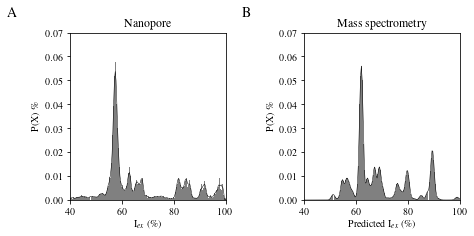

In [138]:
dx = np.diff(Iex_edges_filt*100)[0]
y_lys_MS = np.sqrt(y)/np.sum(np.sqrt(y))

fig_size = (7, 3)
fontsize = 10
letter_font_size = 14
fig = plt.figure( figsize=fig_size )
gs = plt.GridSpec( 1, 2, top=0.9, wspace=0.5, hspace=0.7)

ax0 = fig.add_subplot( gs[ 0, 0 ] )

y2 = np.mean(lysozyme_Iex_spectra[0], axis=0)
ax0.plot(Iex_edges_filt*100, savgol_filter(y2, 7, 3), 'k', linewidth=0.5, alpha=1)
ax0.bar(Iex_edges_filt*100, y2, color='grey', width=0.3, edgecolor='k', linewidth=dx-0.3)


ax0.set_ylabel(r'P(X) \%', fontsize=fontsize)
ax0.set_xlabel(r'I$_{ex}$ (\%)', fontsize=fontsize)
ax0.text( -.4, 1.1, "A", transform=ax0.transAxes, size=letter_font_size, weight='bold' )

ax0.set_title('Nanopore')

ax0.set_ylim(0, 0.07)
ax0.set_xlim(40, 100)

ax1 = fig.add_subplot( gs[ 0, 1 ] )
ax1.plot(Iex_edges_filt*100, y_lys_MS, 'k', linewidth=0.5, alpha=1)
ax1.bar(Iex_edges_filt*100, y_lys_MS, color='grey', width=0.3, edgecolor='k', linewidth=dx-0.3)

ax1.set_ylabel(r'P(X) \%', fontsize=fontsize)
ax1.set_xlabel(r'Predicted I$_{ex}$ (\%)', fontsize=fontsize)
ax1.text( -.4, 1.1, "B", transform=ax1.transAxes, size=letter_font_size, weight='bold' )

ax1.set_ylim(0, 0.07)
ax1.set_xlim(40, 100)

ax1.set_title('Mass spectrometry')

**Figure 1. Lysozyme fingerprinting using FraC-G13W-T1 nanopores. C.** Residual current spectrum as obtained by nanopore electrophysiology using G13F-FraC-T1 and a tryptic digest of Gallus-gallus lysozyme. **D.** Constructed Iex% spectrum from the same tryptic digest of Gallus-gallus analysed by ESI-MS. Each peak indicates a peptide identified by ESI-MS, with Iex% calculated using the calibrated exclusion current % in B. The height of the peak reflects the relative abundance of peptides measured by ESI-MS. The spread of the peak indicates a standard deviation of 0.5 Iex%.

In [139]:
# fig.savefig('Figure_1CD.pdf', format='pdf', dpi=1200, bbox_inches = "tight")

## Multiple protein digests

The following code block defines the protein sequences and ESI-MS results paths

In [140]:
BSA = "DTHKSEIAHRFKDLGEEHFKGLVLIAFSQYLQQCPFDEHVKLVNELTEFAKTCVADESHAGCEKSLHTLFGDELCKVASLRETYGDMADCCEKQEPERNECFLSHKDDSPDLPKLKPDPNTLCDEFKADEKKFWGKYLYEIARRHPYFYAPELLYYANKYNGVFQECCQAEDKGACLLPKIETMREKVLASSARQRLRCASIQKFGERALKAWSVARLSQKFPKAEFVEVTKLVTDLTKVHKECCHGDLLECADDRADLAKYICDNQDTISSKLKECCDKPLLEKSHCIAEVEKDAIPENLPPLTADFAEDKDVCKNYQEAKDAFLGSFLYEYSRRHPEYAVSVLLRLAKEYEATLEECCAKDDPHACYSTVFDKLKHLVDEPQNLIKQNCDQFEKLGEYGFQNALIVRYTRKVPQVSTPTLVEVSRSLGKVGTRCCTKPESERMPCTEDYLSLILNRLCVLHEKTPVSEKVTKCCTESLVNRRPCFSALTPDETYVPKAFDEKLFTFHADICTLPDTEKQIKKQTALVELLKHKPKATEEQLKTVMENFVAFVDKCCAADDKEACFAVEGPKLVVSTQTALA"
PAN = "MAHHHHHHGGVFEEFISTELKKEKKAFTEEFKEEKEINDNSNLKNDLLKEELQEKARIAELESRILKLELEKKELERENLQLAKENEILRRELDRMRVPPLIVGTVVDKVGERKVVVKSSTGPSFLVNVSHFVNPDDLAPGKRVCLNQQTLTVVDVLPENKDYRAKAMEVDERPNVRYEDIGGLEKQMQEIREVVELPLKHPELFEKVGIEPPKGILLYGPPGTGKTLLAKAVATETNATFIRVVGSELVKKFIGEGASLVKDIFKLAKEKAPSIIFIDEIDAIAAKRTDALTGGDREVQRTLMQLLAEMDGFDARGDVKIIGATNRPDILDPAILRPGRFDRIIEVPAPDEKGRLEILKIHTRKMNLAEDVNLEEIAKMTEGCVGAELKAICTEAGMNAIRELRDYVTMDDFRKAVEKIMEKKKVKVKEPAHLDVLYR"
CytC = "GDVEKGKKIFVQKCAQCHTVEKGGKHKTGPNLHGLFGRKTGQAPGFSYTDANKNKGITWGEETLMEYLENPKKYIPGTKMIFAGIKKKGEREDLIAYLKKATNE"
DHFR = "MAHHHHHHGSAMISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLDKPVIMGRHTWESIGRPLPGRKNIILSSQPGTDDRVTWVKSVDEAIAAAGDVPEIMVIGGGRVYEQFLPKAQKLYLTHIDAEVEGDTHFPDYEPDDWESVFSEFHDADAQNSHSYSFEILERR"
TbpA_Y27A = "MGSSHHHHHHSSGLVPRGSHMKPVLTVYTADSFAADWGPGPVVKKAFEADCNCELKLVALEDGVSLLNRLRMEGKNSKADVVLGLDNNLLDAASKTGLFAKSGVAADAVNVPGGWNNDTFVPFDYGYFAFVYDKNKLKNPPQSLKELVESDQNWRVIYQDPRTSTPGLGLLLWMQKVYGDDAPQAWQKLAKKTVTVTKGWSEAYGLFLKGESDLVLSYTTSPAYHILEEKKDNYAAANFSEGHYLQVEVAARTAASKQPELAQKFLQFMVSPAFQNAIPTGNWMYPVANVTLPAGFEKLTKPATTLEFTPAEVAAQRQAWISEWQRAVSR"
lysozyme = "MRSLLILVLCFLPLAALGKVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKKIVSDGNGMNAWVAWRNRCKGTDVQAWIRGCRL"
HMW1Act = "MAHHHHHHVWTANSGALTTLAGSTIKGTESVTTSSQSGDIGGTISGGTVEVKATESLTTQSNSKIKATTGEANVTSATGTIGGTISGNTVNVTANAGDLTVGNGAEINATEGAATLTTSSGKLTTEASSHITSAKGQVNLSAQDGSVAGSINAANVTLNTTGTLTTVKGSNINATSGTLVINAKDAELNGAALGNHTVVNATNANGSGSVIATTSSRVNITGDLITINGLNIISKNGINTVLLKGVKIDVKYIQPGIASVDEVIEAKRILEKVKDLSDEEREALAKLGVSAVRFIEPNNTITVDTQNEFATRPLSRIVISEGRACFSNSDGATVCVNIADNGR"
BetaCasein = "SSSEEVSWISWFCGLRGNEFFCEVDEDYIQDKFNLTGLNEQVPHYRQALDMILDLEPDEELEDNPNQSDLIEQAAEMLYGLIHARYILTNRGIAQMLEKYQQGDFGYCPRVYCENQPMLPIGLSDIPGEAMVKLYCPKCMDVYTPKSSRHHHTDGAYFGTGFPHMLFMVHPEYRPKRPANQFVPRLYGFKIHPMAYQLQLQAASNFKSPVKTIR"
trypsin = "IVGGYTCGANTVPYQVSLNSGYHFCGGSLINSQWVVSAAHCYKSGIQVRLGEDNINVVEGNEQFISASKSIVHPSYNSNTLNNDIMLIKLKSAASLNSRVASISLPTSCASAGTQCLISGWGNTKSSGTSYPDVLKCLKAPILSDSSCKSAYPGQITSNMFCAGYLEGGKDSCQGDSGGPVVCSGKLQGIVSWGSGCAQKNKPGVYTKVCNYVSWIKQTIASN"
EFP = "MKTAQEFRAGQVANINGAPWVIQKAEFNKSGRNAAVVKMKLKNLLTGAGTETVFKADDKLEPIILDRKEVTYSYFADPLYVFMDSEFNQYEIEKDDLEGVLTFIEDGMTDICEAVFYNDKVISVELPTTIVRQIAYTEPAVRGDTSGKVMKTARLNNGAELQVSAFCEIGDSIEIDTRTGEYKSRVKA"
AlphaCasein = "MKLLILTCLVAVALARPKHPIKHQGLPQEVLNENLLRFFVAPFPEVFGKEKVNELSKDIGSESTEDQAMEDIKQMEAESISSSEEIVPNSVEQKHIQKEDVPSERYLGYLEQLLRLKKYKVPQLEIVPNSAEERLHSMKEGIHAQQKEPMIGVNQELAYFYPELFRQFYQLDAYPSGAWYYVPLGTQYTDAPSFSDIPNPIGSENSEKTTMPLW"

'''
sequences = [BSA, PAN, CytC,
            DHFR, TbpA_Y27A, lysozyme,
            HMW1Act, BetaCasein, trypsin, EFP]

protein_labels = ['Bovine Serum Albumin', 'PAN', 'cytochrome c', 
                  'DHFR', 'TbpA-Y27A', 'lysozyme',
                  'HMW1Actin', 'beta casein', 'trypsin', 'EFP']
'''

BSA_MS_PATH = notebook_path + './data/mass_spec/BSA tryptic peptides.xlsx'
PAN_MS_PATH = notebook_path + './data/mass_spec/PAN tryptic peptides.xlsx'
CytC_MS_PATH = notebook_path + './data/mass_spec/CytC tryptic peptides.xlsx'
DHFR_MS_PATH = notebook_path + './data/mass_spec/DHFR tryptic peptides.xlsx'
TbpA_MS_PATH = notebook_path + './data/mass_spec/TbpA tryptic peptides.xlsx'
Lysozyme_MS_PATH = notebook_path + './data/mass_spec/Lysozyme tryptic peptides.xlsx'
HMW1_MS_PATH = notebook_path + './data/mass_spec/HMW1 tryptic peptides.xlsx'
BetaCasein_MS_PATH = notebook_path + './data/mass_spec/beta-casein tryptic peptides.xlsx'
Trypsin_MS_PATH = notebook_path + './data/mass_spec/Trypsin tryptic peptides.xlsx'
EFP_MS_PATH = notebook_path + './data/mass_spec/EF_P_peptide.xlsx'
AlphaCasein_MS_PATH = notebook_path + './data/mass_spec/alpha-casein tryptic peptides.xlsx'


'''

MS_PATHS = [BSA_MS_PATH, PAN_MS_PATH, CytC_MS_PATH,
           DHFR_MS_PATH, TbpA_MS_PATH, Lysozyme_MS_PATH,
           HMW1_MS_PATH, BetaCasein_MS_PATH, Trypsin_MS_PATH,
           EFP_MS_PATH]



protein_labels = ['Bovine Serum Albumin', 'PAN', 'cytochrome c', 
                  'DHFR', 'EFP', 'lysozyme', 'beta casein',
                  'HMW1Actin', 'alpha casein', 'trypsin']

sequences = [BSA, PAN, CytC,
            DHFR, EFP, lysozyme,
            HMW1Act, AlphaCasein, trypsin]

MS_PATHS = [BSA_MS_PATH, PAN_MS_PATH, CytC_MS_PATH,
           DHFR_MS_PATH, EFP_MS_PATH, Lysozyme_MS_PATH,
           HMW1_MS_PATH, AlphaCasein_MS_PATH, Trypsin_MS_PATH]
'''

"\n\nMS_PATHS = [BSA_MS_PATH, PAN_MS_PATH, CytC_MS_PATH,\n           DHFR_MS_PATH, TbpA_MS_PATH, Lysozyme_MS_PATH,\n           HMW1_MS_PATH, BetaCasein_MS_PATH, Trypsin_MS_PATH,\n           EFP_MS_PATH]\n\n\n\nprotein_labels = ['Bovine Serum Albumin', 'PAN', 'cytochrome c', \n                  'DHFR', 'EFP', 'lysozyme', 'beta casein',\n                  'HMW1Actin', 'alpha casein', 'trypsin']\n\nsequences = [BSA, PAN, CytC,\n            DHFR, EFP, lysozyme,\n            HMW1Act, AlphaCasein, trypsin]\n\nMS_PATHS = [BSA_MS_PATH, PAN_MS_PATH, CytC_MS_PATH,\n           DHFR_MS_PATH, EFP_MS_PATH, Lysozyme_MS_PATH,\n           HMW1_MS_PATH, AlphaCasein_MS_PATH, Trypsin_MS_PATH]\n"

In [141]:
protein_labels = ['Bovine Serum Albumin', 'DHFR', 'EFP',
                  'HMW1Actin', 'PAN', 'alpha casein',
                  'beta casein', 'cytochrome c', 'trypsin']

sequences = [BSA, DHFR, EFP,
             HMW1Act, PAN, AlphaCasein,
             BetaCasein, CytC, trypsin]
              

MS_PATHS = [BSA_MS_PATH, DHFR_MS_PATH, EFP_MS_PATH,
            HMW1_MS_PATH, PAN_MS_PATH, AlphaCasein_MS_PATH,
            BetaCasein_MS_PATH, CytC_MS_PATH, Trypsin_MS_PATH]
            

In [142]:
protein_labels2 = protein_labels + ['lysozyme']
sequences2 = sequences + [lysozyme]
MS_PATHS2 = MS_PATHS + [Lysozyme_MS_PATH]

For simplicity, we wrote a function to perform the sum of all peptide NDFs (*vide supra*)

In [143]:
def get_mass_area_MS(filepath):
    df = pd.read_excel(filepath)
    
    import re
    fragment_seq = []
    fragment_mass = []
    fragment_area = []
    
    for peptide, area in zip(df['Peptide'], df['Area']):
        fragment_seq.append(re.sub("[\(\[].*?[\)\]]", "", peptide))
        fragment_mod = np.sum(
            [float(i) for i in re.findall(".*?\((.*?)\)", peptide)]
        )
        fragment_mass.append(PD.get_peptide(fragment_seq[-1], 'mass', cystein_mod=0) + fragment_mod)
        fragment_area.append(np.sqrt(area))
    
    return fragment_mass, fragment_area

def estimate_Iex(filepath, popt_peptides_polyfit):
    df = pd.read_excel(filepath)
    
    import re
    fragment_seq = []
    fragment_mass = []
    fragment_area = []
    
    for peptide, area in zip(df['Peptide'], df['Area']):
        fragment_seq.append(re.sub("[\(\[].*?[\)\]]", "", peptide))
        fragment_mod = np.sum(
            [float(i) for i in re.findall(".*?\((.*?)\)", peptide)]
        )
        fragment_mass.append(PD.get_peptide(fragment_seq[-1], 'mass', cystein_mod=0) + fragment_mod)
        fragment_area.append(area)
    
    
    n_res = 1001
    STD = 0.5
    y = np.zeros(n_res)
    x = np.linspace(0, 100, n_res)
    for seq, mass, area in zip(fragment_seq, fragment_mass, fragment_area):
        y += NDF(x, area, popt_peptides_polyfit(mass), STD)
    return y, x

The following code block generates the figure, subsequently followed by a line to save the figure.

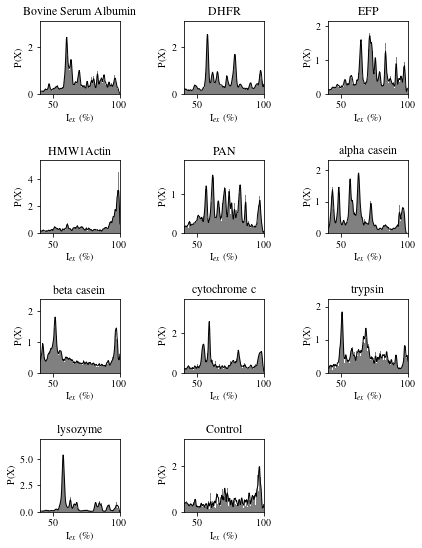

In [144]:
protein_labels3 = protein_labels + ['lysozyme'] + ['Control']

n_rows = 4
n_cols = 3
row_height = 2.2 # Horizontal
# row_height = 1.8 # Vertical
dx = np.diff(Iex_edges_filt*100)[0]
fig_size = (min(2.2*n_cols, 9), row_height*n_rows)
letter_font_size = 14
fontsize = 10
fig = plt.figure( figsize=fig_size )
gs = plt.GridSpec( n_rows, n_cols, top=0.9, wspace=0.8, hspace=0.9)

min_mass = 700
max_mass = 2000
ax = []
k = 0
for label in protein_labels3:
    row = int((k - (k % n_cols)) / n_cols)
    col = int( k % n_cols )
    data = results.where( results.loc[:,'Protein'] == label ).dropna()
    _, Iex_spectrum = NM.get_spectra_all(data)
    
    ax.append(fig.add_subplot( gs[ row, col ] ))
    y = np.mean(Iex_spectrum[0], axis=0)
    
    ax[-1].plot(Iex_edges_filt*100, 100*savgol_filter(y / np.sum(y), 7, 2), 'k', linewidth=1, alpha=1)
    ax[-1].bar(Iex_edges_filt*100, 100*y / np.sum(y), color='grey', width=0.3, edgecolor='k', linewidth=dx-0.3)
    ax[-1].set_title(label)
    ax[-1].set_xlim(40, 100)
    ax[-1].set_ylim(0, 100*max(y / np.sum(y))*1.2)
    ax[-1].set_ylabel(r'P(X) %', fontsize=fontsize)
    ax[-1].set_xlabel(r'I$_{ex}$ (\%)', fontsize=fontsize)
    k += 1

**Figure 2. Protein identification using nanopore spectrometry. A.** Resulting baseline corrected residual current spectra of 9 tryptic digested proteins. The vertical lines represent the peptides as measured by ESI-MS, mapped to the Iex%. The opacity of the vertical lines represents the intensity as measured by ESI-MS. 

In [145]:
# fig.savefig('Figure_2A.pdf', format='pdf', dpi=1200, bbox_inches = "tight")

To match the spectra, we use a different cut-off (based on the peptides), so we define a new NanoMatch class instance.

In [146]:
n_bins2=100
Iex_bins_filt2 = np.linspace( 0.5, 0.98, n_bins2 + 1 )
Iex_edges_filt2 = np.linspace( 0.5, 0.98, n_bins2 )

from NanoMatch import *
NM2 = NanoMatch( Iex_bins=Iex_bins_filt2, Iex_edges=Iex_edges_filt2 )

protein_names, iex_spectra = NM2.get_spectra_all( results )

Now we determine the correlation between the I<sub>ex</sub>% spectra.<br>
First load the names of the proteins as `protein names` and the I<sub>ex</sub>% spectra as `iex_spectra`.

In [147]:
def SNV(x):
    return (x-np.mean(x))/np.std(x)


Iex_spectra = []
protein_name_labels = []
for c, i in enumerate(iex_spectra):
    k = []
    
    for j in i:
        k.append(SNV(j))
    if c!=1:
        Iex_spectra.append(k)
        protein_name_labels.append(protein_names[c])

Load the *ad hoc* `ScoreSpectra` method as `Score`.

In [148]:
Score = ScoreSpectra()
Rs = Score.leave_one_out( Iex_spectra, method='DEuc' )

We compile a database to score against as `Iex_spectra`.<br>
The `score_spectra( Iex_spectra, method='DEuc', *args )` is used to calculate the Squared first difference correlation coefficient.
> Other options include:
>>Correlation method, valid entries: `"Cor"`, `"DCor"`, `"Euc"` and `"DEuc"`.
>>
>>`"Cor"`: Correlation coefficient
>>
>>`"DCor"`: Squared first difference correlation coefficient
>>
>>`"Euc"`: Euclidean cosine
>>
>>`"DEuc"`: Squared first difference Euclidean cosine

The `Score` method also contains a plotting function `plot_Rs( protein_labels, Rs, *args )`, which is used to plot the P(X).


The `leave_one_out( X, method='DEuc', *args )` is used to calculate the Squared first difference correlation coefficien, between the spectra and the data, by leaving the spectrum that is tested out of the database.

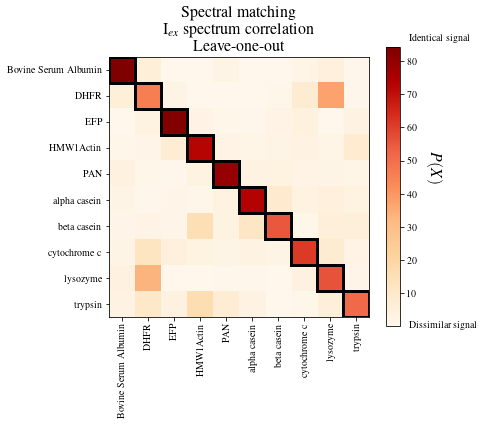

In [149]:
fig = Score.plot_Rs( protein_name_labels, Rs, title='Spectral matching \n' + r'I$_{ex}$ spectrum correlation' + '\nLeave-one-out' )

**Figure 2. Protein identification using nanopore spectrometry. B.** Leave-one-out spectral matching of the baseline corrected residual current spectra using Euclidean cosine cross-correlation. With on the Y-axis the protein that is being matched using leave-one-out matching with the proteins on the X-axis. The black boxes represent the matches with the highest score.

In [150]:
# fig.savefig('Figure_2B.pdf', format='pdf', dpi=1200, bbox_inches = "tight")

# Supplementary figures

## Supplementary Figure 2

We can plot the I</sub>ex</sub>% spectra using `NM.plot_Iex_spectra( results, *args )`, we plot it without spectral allignment.

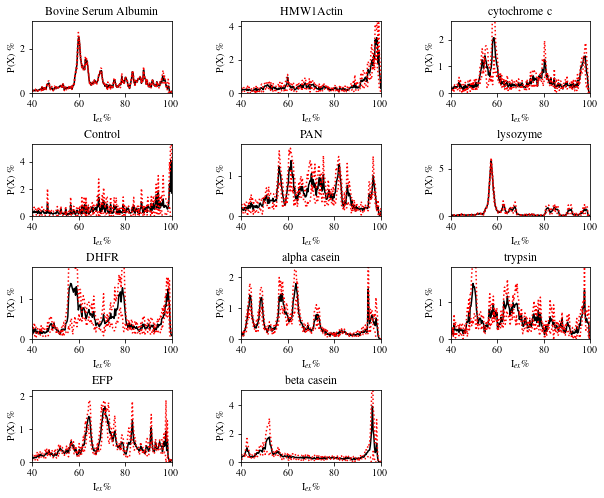

In [151]:
fig = NM.plot_Iex_spectra( results, allign=False )

**Figure S1. Residual current spectra without re-alignment.** Resulting residual current spectrum of 9 tryptic digested proteins prior to spectral re-alignment.

In [152]:
# fig.savefig('Figure_S2.pdf', format='pdf', dpi=1200, bbox_inches = "tight")

## Supplementary Figure 3

Notice that the spectra seem to be noisy, we can see if this is due to a baseline shift. By calculating the error between a reference spectrum and the spectrum to check (by addition or substraction of residual current %). The function `plot_shift_error( results, *args )` in `NM` can show the shift error. We expect that there will be a clear minimum, and set that as a relative shift.

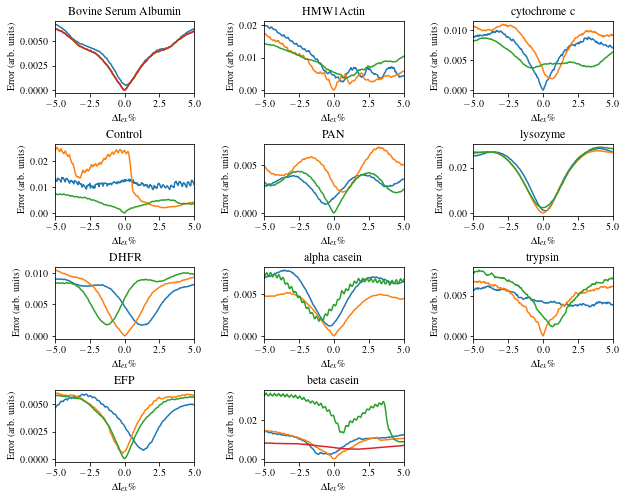

In [153]:
fig = NM.plot_shift_error(results)

**Figure S2. Residual current re-alignment error.** Re-alignment error of 9 tryptic digested proteins.

In [154]:
# fig.savefig('Figure_S3.pdf', format='pdf', dpi=1200, bbox_inches = "tight")

## Supplementary Figure 4

We can plot the corrected I<sub>ex</sub>% spectra using `NM.plot_Iex_spectra( results, *args )`.

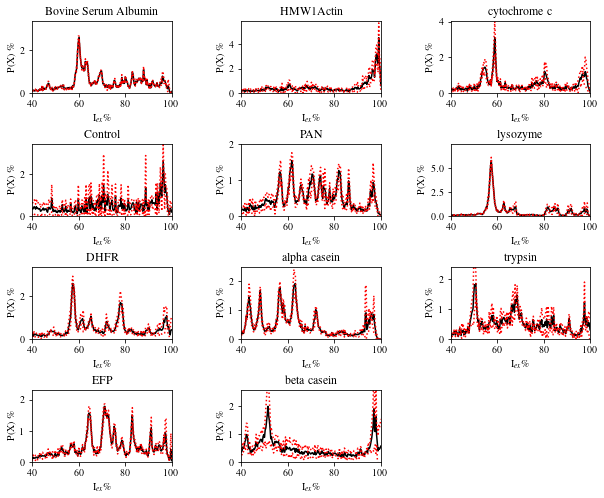

In [155]:
fig = NM.plot_Iex_spectra( results, allign=True )

**Figure S4. Residual current spectra with re-alignment.** Resulting residual current spectrum of 9 tryptic digested proteins after spectral re-alignment.

In [156]:
# fig.savefig('Figure_S4.pdf', format='pdf', dpi=1200, bbox_inches = "tight")

## Supplementary Figure 5

In [157]:
def make_figure_S5(protein_labels, sequences, MS_PATHS, results, popt_peptides_polyfit, idx=None):
    if not idx:
        idx = [i for i in range(len(protein_labels))]
    fig_size = (7, 2*len(idx))
    letter_font_size = 14
    fontsize = 10
    fig = plt.figure( figsize=fig_size )
    gs = plt.GridSpec( len(idx), 3, top=0.9, wspace=0.7, hspace=0.9)
    for row, (label, sequence, MS_PATH) in enumerate(
        zip(np.array(protein_labels)[idx], np.array(sequences)[idx], np.array(MS_PATHS)[idx])):
        data = results.where( results.loc[:,'Protein'] == label ).dropna()
        
        # Ires vs dwell time
        iex = np.array([])
        dwt = np.array([])
        for i, j in zip(data['Iex'], data['dwelltime']):
            iex = np.concatenate((iex, i))
            dwt = np.concatenate((dwt, j))
        
        ax.append(fig.add_subplot( gs[ row, 0 ] ))
        
        # ax[-1].set_title('%s' % label)
        # ax[-1].semilogy(iex[::10]*100, dwt[::10], '.k', markersize=0.5)
        ax[-1].semilogy(iex*100, dwt, '.k', markersize=0.1)
        ax[-1].set_ylabel(r'Dwell time (s)', fontsize=fontsize)
        ax[-1].set_xlabel(r'I$_{ex}$ (\%)', fontsize=fontsize)
        ax[-1].set_ylim(4e-4, 1)
        ax[-1].set_xlim(40, 95)
        ax[-1].set_yticks([5e-4, 1e-3, 1e-2, 1e-1])
        
        
        # Ires spectrum
        ax.append(fig.add_subplot( gs[ row, 1 ] ))
        _, Iex_spectrum = NM.get_spectra_all(data)
        
        idx = np.where(Iex_edges_filt<1)
        
        x = Iex_edges_filt[idx]*100
        dx = np.diff(x)[0]
        
        y = np.mean(Iex_spectrum[0], axis=0)[idx]
        y = (y / np.sum(y))
        # ax[-1].plot(x, 100*y, 'k', linewidth=2)
        
        ax[-1].plot(x, 100*savgol_filter(y, 7, 2), 'k', linewidth=1, alpha=1)
        ax[-1].bar(x, 100*y, color='grey', width=0.3, edgecolor='k', linewidth=dx-0.3)
        
        if label == "HMW1Actin":
            ax[-1].set_title("HMW1ct")
        else:
            ax[-1].set_title('%s' % label)
        ax[-1].set_xlim(45, 100)
        ax[-1].set_ylim(0, 100*max(y)*1.2)
        ax[-1].set_ylabel(r'P(X) %', fontsize=fontsize)
        ax[-1].set_xlabel(r'I$_{ex}$ (\%)', fontsize=fontsize)
        
        # In-silico digest
        # fragment_seq, _, _, _, _, _ = PD.digest( sequence, glycosylate=False )
        # fragment_mass = [PD.get_peptide(i, 'mass') for i in fragment_seq]
        # for mass in fragment_mass:
        #     ax[-1].axvline(logistic(mass,*popt_peptides), c='b', alpha=0.5)
    
        
        # Constructed Iex spectrum
        ax.append(fig.add_subplot( gs[ row, 2 ] ))
        fragment_mass, fragment_area = get_mass_area_MS(MS_PATH)
        fragment_area = np.array(fragment_area)/max(np.array(fragment_area))
    
        n_res = 200
        STD = 0.5
        y2 = np.zeros(len(x))
        # x = np.linspace(40, 100, n_res)
        for mass, area in zip(fragment_mass, fragment_area):
            y2 += NDF(x, area, popt_peptides_polyfit(mass), STD)
            # ax[-2].axvline(logistic(mass,*popt_peptides), c='r', alpha=(area/max(fragment_area))**2)
            # ax[-3].axvline(logistic(mass,*popt_peptides), c='r', alpha=(area/max(fragment_area))**2)
        y2 = (y2 / np.sum(y2))
        # ax[-1].plot(x, 100*y2, 'k', linewidth=2)
        
        ax[-1].plot(x, 100*savgol_filter(y2, 7, 2), 'k', linewidth=1, alpha=1)
        ax[-1].bar(x, 100*y2, color='grey', width=0.3, edgecolor='k', linewidth=dx-0.3)
        
        ax[-1].set_xlim(45, 100)
        ax[-1].set_ylim(0, 100*max(y2)*1.2)
        ax[-1].set_ylabel(r'P(X) %', fontsize=fontsize)
        ax[-1].set_xlabel(r'I$_{ex, MS}$ (\%)', fontsize=fontsize)
        
        print((np.sum(np.diff(y)*np.diff(y2))**2)/(np.sum(np.sqrt(np.diff(y)**2))*np.sum(np.sqrt(np.diff(y2)**2))))
    return fig

1.89052273473876e-08
2.1493556623036392e-07


KeyboardInterrupt: 

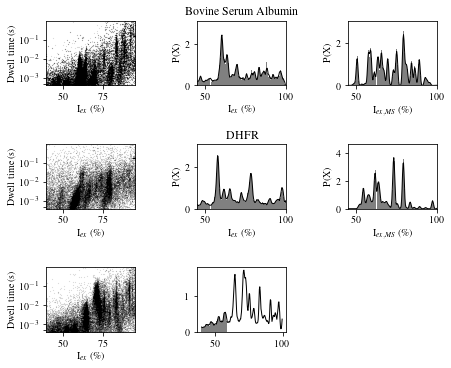

In [158]:
idx = [0, 1, 2, 3, 4]
fig_S5_a = make_figure_S5(protein_labels2, sequences2, MS_PATHS2, results, popt_peptides_polyfit, idx=idx)

1.6136613034200428e-08
6.213421805500489e-08
2.9060635826555592e-08
1.1438416315344468e-08
3.084199795504381e-07


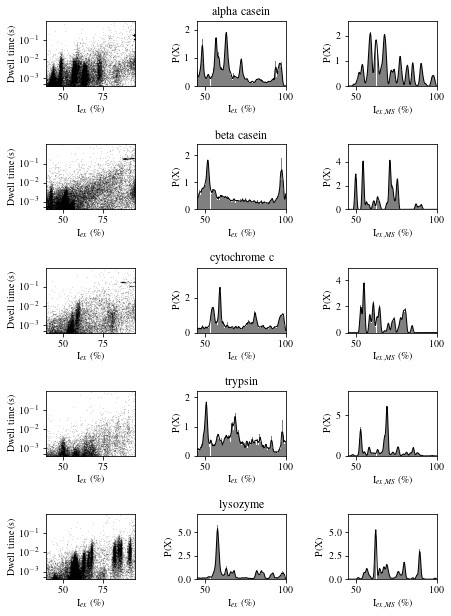

In [ ]:
idx = [5, 6, 7, 8, 9]
fig_S5_b = make_figure_S5(protein_labels2, sequences2, MS_PATHS2, results, popt_peptides_polyfit, idx=idx)

**Figure S5.  _I<sub>ex</sub>%_ vs dwelltime, _I<sub>ex</sub>%_ spectrum and contructed _I<sub>ex</sub>%_ spectra.**

In [ ]:
# fig_S5_a.savefig('Figure_S5a.png', format='png', dpi=1200, bbox_inches = "tight")

In [ ]:
# fig_S5_b.savefig('Figure_S5b.png', format='png', dpi=1200, bbox_inches = "tight")

## Supplementary Figure 6

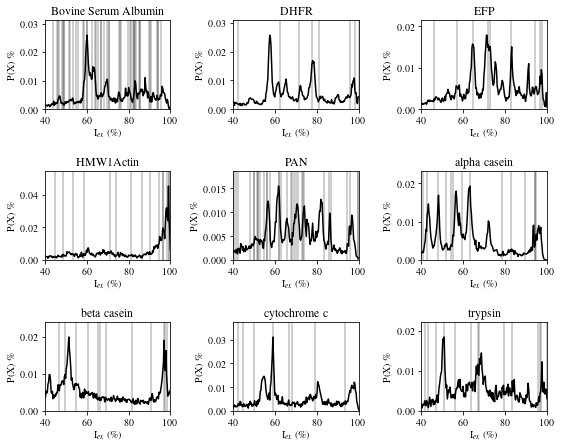

In [ ]:
fig_size = (9, 7)
letter_font_size = 14
fontsize = 10
fig = plt.figure( figsize=fig_size )
gs = plt.GridSpec( 3, 3, top=0.9, wspace=0.5, hspace=0.7)


min_mass = 700
max_mass = 2000
ax = []
k = 0
for label, sequence in zip(protein_labels, sequences):
    row = int((k - (k % 3)) / 3)
    col = int( k % 3 )
    data = results.where( results.loc[:,'Protein'] == label ).dropna()
    _, Iex_spectrum = NM.get_spectra_all(data)
    
    ax.append(fig.add_subplot( gs[ row, col ] ))
    y = np.mean(Iex_spectrum[0], axis=0)
    ax[-1].plot(Iex_edges_filt*100, y / np.sum(y), 'k')
    ax[-1].set_title(label)
    ax[-1].set_xlim(40, 100)
    ax[-1].set_ylim(0, max(y / np.sum(y))*1.2)
    ax[-1].set_ylabel(r'P(X) \%', fontsize=fontsize)
    ax[-1].set_xlabel(r'I$_{ex}$ (\%)', fontsize=fontsize)
    
    
    fragment_seq, _, _, _, _, _ = PD.digest( sequence, glycosylate=False )
    fragment_mass = [PD.get_peptide(i, 'mass') for i in fragment_seq]
    fragment_Iex = [popt_peptides_polyfit(mass) for mass in fragment_mass]
    
    score = []
    dX = np.linspace(-5, 5, 100)
    for dx in dX:
        overlap = 0
        for iex in fragment_Iex:    
            idx = np.where((Iex_edges_filt*100>iex-0.5+dx) & (Iex_edges_filt*100<iex+0.5+dx))[0]
            overlap += np.sum(y[idx])
        score.append(overlap)
    
    for iex in fragment_Iex:
        ax[-1].axvline(iex + dX[score.index(max(score))], c='k', alpha=0.25)
    k += 1

**Figure S6. Protein identification using nanopore spectrometry.** Resulting baseline corrected residual current spectra of 9 tryptic digested proteins. The vertical lines represent the peptides as predicted *in-silico*, mapped to the Iex%. 

In [ ]:
# fig.savefig('Figure_S6.pdf', format='pdf', dpi=1200, bbox_inches = "tight")

## Supplementary Figure 7

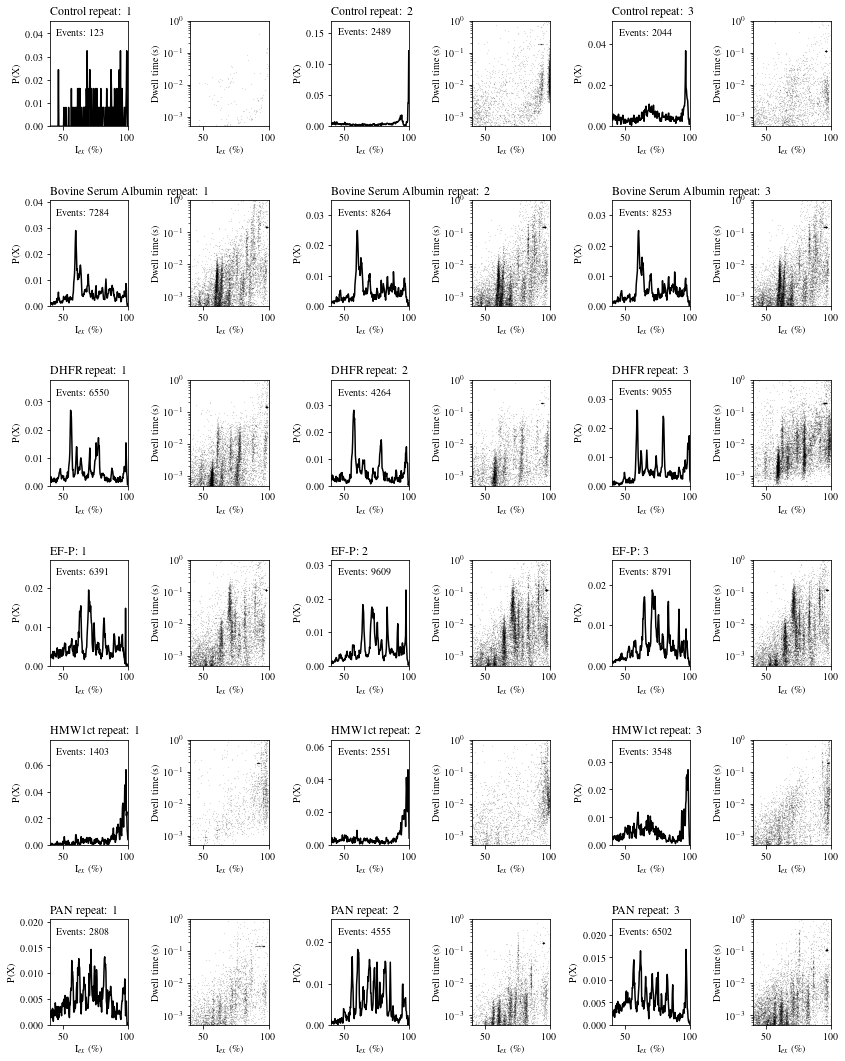

In [ ]:

letter_font_size = 14
fontsize = 10

min_mass = 700
max_mass = 2000
ax = []
k = 0

selected_labels = ['Control', 'Bovine Serum Albumin', 'DHFR', 'EFP',
                  'HMW1Actin', 'PAN']

fig_size = (14, (len(selected_labels))*3)
fig = plt.figure( figsize=fig_size )
gs = plt.GridSpec(len(selected_labels), 6, top=0.9, wspace=0.8, hspace=0.7)
for label in selected_labels:
    row_no = int((k - (k % 6)) / 6)
    
    data = results.where( results.loc[:,'Protein'] == label ).dropna()
    
    for index, row in data[0:3].iterrows():
        char_vars = list( zip( row['Iex'], row['Iex SD2'], row['dwelltime'], row['beta'] ) )
        keep_rows = NM._get_rows( row['Iex'], beta=row['beta'], dwelltime=row['dwelltime'] )
        iex_spectrum = NM._get_spectrum( row['Iex'][keep_rows], beta=row['beta'][keep_rows], dwelltime=row['dwelltime'][keep_rows] )
        
        col = int( k % 6 )
        ax.append(fig.add_subplot( gs[ row_no, col ] ))
        ax[-1].plot(Iex_edges_filt*100, iex_spectrum, 'k')
        if col % 2 == 0:
            if label == "HMW1Actin":
                ax[-1].set_title('HMW1ct repeat: ' + str(int(1+col/2)), loc='left', fontweight='bold')
            elif label == "EFP":
                ax[-1].set_title('EF-P: ' + str(int(1+col/2)), loc='left', fontweight='bold')
            else:
                ax[-1].set_title(label + ' repeat: ' + str(int(1+col/2)), loc='left', fontweight='bold')
        ax[-1].set_xlim(40, 100)
        ax[-1].set_ylim(0, max(iex_spectrum / np.sum(iex_spectrum))*1.4)
        ax[-1].set_ylabel(r'P(X) %', fontsize=fontsize)
        ax[-1].set_xlabel(r'I$_{ex}$ (\%)', fontsize=fontsize)
        ax[-1].text(45,max(iex_spectrum / np.sum(iex_spectrum))*1.2,'Events: %s' % len(keep_rows[0]))
        
        k+=1
        
        col = int( k % 6 )
        ax.append(fig.add_subplot( gs[ row_no, col ] ))
        ax[-1].semilogy(row['Iex'][keep_rows]*100, row['dwelltime'][keep_rows], '.k', markersize=0.1)
        ax[-1].set_xlim(40, 100)
        ax[-1].set_ylim(5e-4, 1)
        ax[-1].set_ylabel(r'Dwell time (s)', fontsize=fontsize)
        ax[-1].set_xlabel(r'I$_{ex}$ (\%)', fontsize=fontsize)
        
        k+=1

In [ ]:
# fig.savefig('Figure_S7a.png', format='png', dpi=1200, bbox_inches = "tight")

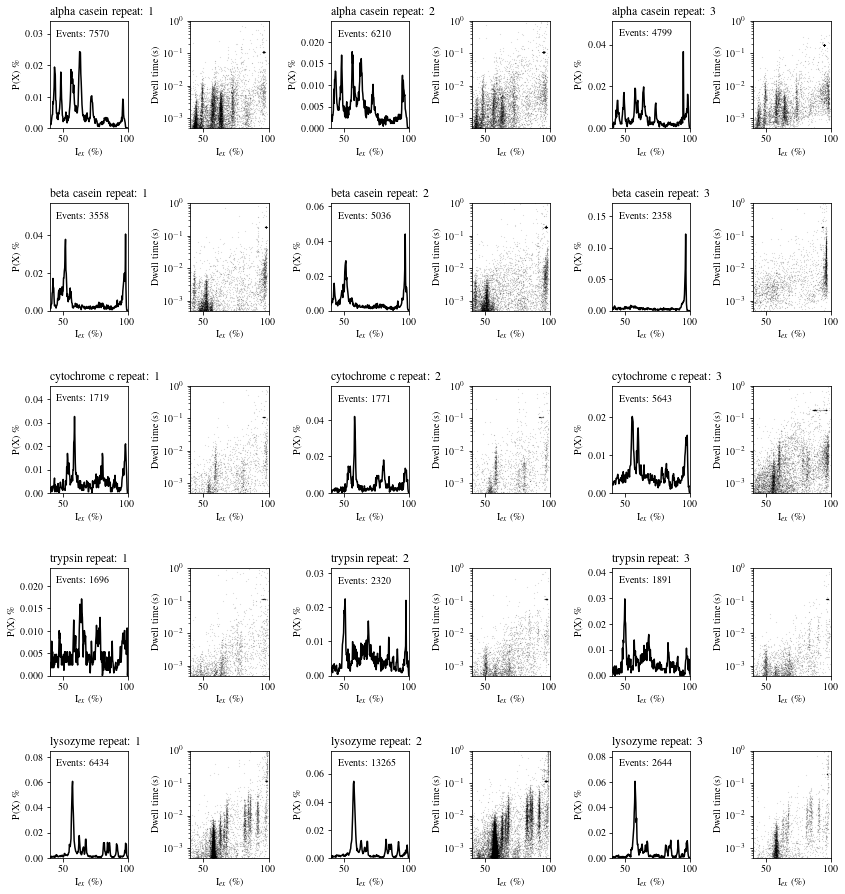

In [ ]:

letter_font_size = 14
fontsize = 10

min_mass = 700
max_mass = 2000
ax = []
k = 0
selected_labels = ['alpha casein',
                  'beta casein', 'cytochrome c', 'trypsin','lysozyme']

fig_size = (14, (len(selected_labels))*3)
fig = plt.figure( figsize=fig_size )
gs = plt.GridSpec(len(selected_labels), 6, top=0.9, wspace=0.8, hspace=0.7)
for label in selected_labels:
    row_no = int((k - (k % 6)) / 6)
    
    data = results.where( results.loc[:,'Protein'] == label ).dropna()
    
    for index, row in data[0:3].iterrows():
        char_vars = list( zip( row['Iex'], row['Iex SD2'], row['dwelltime'], row['beta'] ) )
        keep_rows = NM._get_rows( row['Iex'], beta=row['beta'], dwelltime=row['dwelltime'] )
        iex_spectrum = NM._get_spectrum( row['Iex'][keep_rows], beta=row['beta'][keep_rows], dwelltime=row['dwelltime'][keep_rows] )
        
        col = int( k % 6 )
        ax.append(fig.add_subplot( gs[ row_no, col ] ))
        ax[-1].plot(Iex_edges_filt*100, iex_spectrum, 'k')
        if col % 2 == 0:
            if label == "HMW1Actin":
                ax[-1].set_title('HMW1ct repeat: ' + str(int(1+col/2)), loc='left', fontweight='bold')
            else:
                ax[-1].set_title(label + ' repeat: ' + str(int(1+col/2)), loc='left', fontweight='bold')
        ax[-1].set_xlim(40, 100)
        ax[-1].set_ylim(0, max(iex_spectrum / np.sum(iex_spectrum))*1.4)
        ax[-1].set_ylabel(r'P(X) \%', fontsize=fontsize)
        ax[-1].set_xlabel(r'I$_{ex}$ (\%)', fontsize=fontsize)
        ax[-1].text(45,max(iex_spectrum / np.sum(iex_spectrum))*1.2,'Events: %s' % len(keep_rows[0]))
        
        k+=1
        
        col = int( k % 6 )
        ax.append(fig.add_subplot( gs[ row_no, col ] ))
        ax[-1].semilogy(row['Iex'][keep_rows]*100, row['dwelltime'][keep_rows], '.k', markersize=0.1)
        ax[-1].set_xlim(40, 100)
        ax[-1].set_ylim(5e-4, 1)
        ax[-1].set_ylabel(r'Dwell time (s)', fontsize=fontsize)
        ax[-1].set_xlabel(r'I$_{ex}$ (\%)', fontsize=fontsize)
        
        k+=1

In [ ]:
# fig.savefig('Figure_S7b.png', format='png', dpi=1200, bbox_inches = "tight")

## Figure 1B: Trace

In [ ]:
# sNDF: super Normal Distribution Function
def sNDF( x, A, x0, sigma, B, C ):
    E = -( ( x - x0 )**2 / ( 2 * sigma**2 ) )**B
    return ( A*exp( E ) ) + C

In [ ]:
fname = notebook_path +  "/data/Lysozyme synthetic peptides/0001/2020_05_20_1M_KCl_50mM_Citricacid_BTP_pH38_FraC_G13F_min70_blank_08ul_Lys1_08ul_Lys2alk_08ul_Lys3_08ul_Lys4alk_08ul_Lys5_08ul_Lys6alk_08ul_Lys7_RV_0001.abf"

In [ ]:
signal, sampling_period = nl.loadAxon(fname)

Unable to load .abf file


TypeError: cannot unpack non-iterable NoneType object

NameError: name 'sampling_period' is not defined

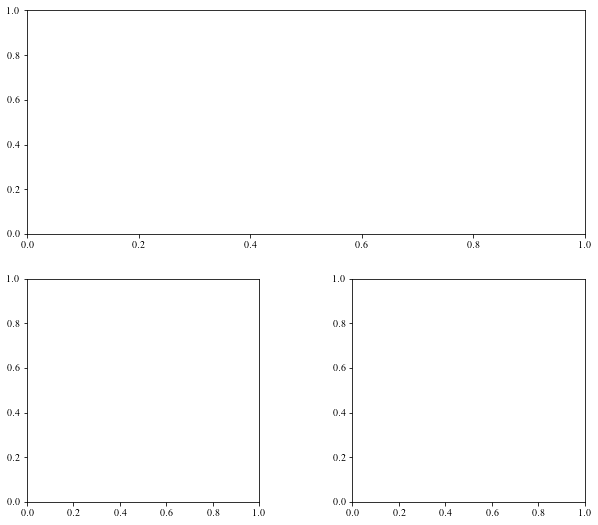

In [ ]:
fig_size = (10, 7)
fig = plt.figure( figsize=fig_size )

gs = plt.GridSpec(2, 2, top=1.1, wspace=0.4, hspace=0.2)
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])


t0x = 2.5
dtx = 1
d0x = int(t0x / sampling_period)
d1x = int((t0x + dtx) / sampling_period)
print(d1x-d0x)

Iex = []
ax1.plot(np.linspace(0, dtx, int(d1x - d0x)), signal[0][d0x:d1x], color='grey', linewidth=0.2)

ax1.set_ylim(-130, 40)
ax1.set_xlim(0, dtx)
ax1.set_ylabel(r'$Current$ (pA)', fontsize=10)
ax1.set_yticks([-100, -50, 0])
ax1.set_xticks([])
ax1.axhline(24, xmin=0.1, xmax=0.2, linewidth=5, color='k')
ax1.text(0.15, 27, '100 ms', fontsize=12, ha='center', va='bottom')

levels = (False, -110.5, 8)
L0, L1, L0_start, L0_end, L1_start, L1_end = nl.thresholdsearch([signal[0]], sampling_period, levels, dwelltime=1e-4)


rect = []
x_fit = np.linspace(t0x, t0x + dtx, int(dtx / sampling_period))
y_fit = []
for i, var in enumerate(zip(L0, L1, L0_start, L0_end, L1_start, L1_end)):
    l0, l1, l0_start, l0_end, l1_start, l1_end = var
    if ((l1_end * sampling_period < t0x + dtx * 2) and (l1_start * sampling_period > t0x - dtx * 2)):
        # Combine the event back with it's surrounding baseline
        Y = np.concatenate((L0[i], L1[i], L0[i + 1]))

        # Get some range of x
        x = np.linspace(L0_start[i] * sampling_period, (L0_start[i] + len(Y)) * sampling_period, len(Y))

        # Estimate location of x0
        x0 = (len(L0[i]) + len(L1[i]) / 2) * sampling_period
        x0 = (l1_start + ((l1_end - l1_start) / 2)) * sampling_period

        # Estimate the sigma
        sigma_x0 = (len(L1[i]) / 2) * sampling_period

        # Parameters [amplitude, x0, sigma_x, Beta, offset]
        # Beta=2 -> Normal distribution
        p0 = (abs(np.mean(L1[i]) - np.mean(np.concatenate((L0[i], L0[i + 1])))),
              x0, sigma_x0, 1, np.mean(np.concatenate((L0[i], L0[i + 1]))))

        try:
            # Fit a super normal distribution to the event
            popt, pcov = curve_fit(sNDF, x, abs(Y)*-1, p0=p0)
            Iex.append(popt[0]/abs(popt[-1]))
            if ( popt[1] > t0x and popt[1] < t0x + dtx ):
                y_fit.append(sNDF(x_fit, *popt))
        except:
            print(1)
    if (l1_start > d0x - (1 / sampling_period)) & (l1_end < d1x + (1 / sampling_period)):
        rect.append(
            patches.Rectangle(((l1_start - d0x) * sampling_period, 0), (l1_end - l1_start) * sampling_period, 10,
                              linewidth=1, edgecolor='gray', facecolor='white', hatch='///'))
        ax1.add_patch(rect[-1])
ax1.plot(x_fit - t0x, np.amax(y_fit, axis=0), 'k', linewidth=2, alpha=0.8)

t0x = 3.05
dtx = 0.1
d0x = int(t0x / sampling_period)
d1x = int((t0x + dtx) / sampling_period)
ax2.plot(np.linspace(0, dtx, int(d1x - d0x)), signal[0][d0x:d1x], color='grey', linewidth=0.2)
ax2.set_ylim(-130, 40)
ax2.set_xlim(0, dtx)
ax2.set_ylabel(r'$Current$ (pA)', fontsize=10)
ax2.set_yticks([-100, -50, 0])
ax2.set_xticks([])
ax2.axhline(24, xmin=0.1, xmax=0.2, linewidth=5, color='k')
ax2.text(0.015, 27, '10 ms', fontsize=12, ha='center', va='bottom')
rect = []
x_fit = np.linspace(t0x, t0x + dtx, int(dtx / sampling_period))
y_fit = []
for i, var in enumerate(zip(L0, L1, L0_start, L0_end, L1_start, L1_end)):
    l0, l1, l0_start, l0_end, l1_start, l1_end = var
    if ((l1_end * sampling_period < t0x + dtx * 2) and (l1_start * sampling_period > t0x - dtx * 2)):
        # Combine the event back with it's surrounding baseline
        Y = np.concatenate((L0[i], L1[i], L0[i + 1]))

        # Get some range of x
        x = np.linspace(L0_start[i] * sampling_period, (L0_start[i] + len(Y)) * sampling_period, len(Y))

        # Estimate location of x0
        x0 = (len(L0[i]) + len(L1[i]) / 2) * sampling_period
        x0 = (l1_start + ((l1_end - l1_start) / 2)) * sampling_period

        # Estimate the sigma
        sigma_x0 = (len(L1[i]) / 2) * sampling_period

        # Parameters [amplitude, x0, sigma_x, Beta, offset]
        # Beta=2 -> Normal distribution
        p0 = (abs(np.mean(L1[i]) - np.mean(np.concatenate((L0[i], L0[i + 1])))),
              x0, sigma_x0, 1, np.mean(np.concatenate((L0[i], L0[i + 1]))))

        try:
            # Fit a super normal distribution to the event
            popt, pcov = curve_fit(sNDF, x, abs(Y)*-1, p0=p0)
            if ( popt[1] > t0x and popt[1] < t0x + dtx ):
                y_fit.append(sNDF(x_fit, *popt))
        except:
            print(1)
    if (l1_start > d0x - (1 / sampling_period)) & (l1_end < d1x + (1 / sampling_period)):
        rect.append(
            patches.Rectangle(((l1_start - d0x) * sampling_period, 0), (l1_end - l1_start) * sampling_period, 10,
                              linewidth=1, edgecolor='gray', facecolor='white', hatch='///'))
        ax2.add_patch(rect[-1])
ax2.plot(x_fit - t0x, np.amax(y_fit, axis=0), 'k', linewidth=2, alpha=0.8)

ax3.hist( np.array(Iex)*100, bins=np.linspace(40, 100, 60) )
ax3.set_xlabel(r'$I_{ex}$%', fontsize=10)
ax3.set_ylabel(r'$Counts$ (a.u.)', fontsize=10)
ax3.set_yticks([])
ax3.set_xticks([40, 60, 80, 100])


In [ ]:
# fig.savefig('Figure_1b_trace.pdf', format='pdf', dpi=1200, bbox_inches = "tight")

: 

# Fine

: 